# <span style="color:red"><u>Background</u></span>
This dataset is taken from Kaggle competition (https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/).
Walmart has challanged the participants to predict the weekly sales of their 45 stores during Nov'12 - July'18 period. They provided historical data for a period of Feb'10 to Nov'12 to establish a model and upload the results to get the score against actual actual sales data. The challange has a bit of added complexity due to lots of missing data for markdowns during special holiday periods.

`'Mean Absolute Error'` has been used as the performance metric to evaluate the performance

## <span style="color:blue"><u>1. Introduction to the dataset</u></span>
Dataset covers 45 Walmart stores located in different regions. Each store contains a number of departments, and we are tasked with predicting the department-wide sales for each store.

Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

<b>stores.csv</b>

This file contains anonymized information about the 45 stores, indicating the type and size of store.

<b>train.csv</b>

This is the historical training data, which covers to 2010-02-05 to 2012-11-01 with following fields:

Store - the store number
Dept - the department number
Date - the week
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week

<b>test.csv</b>

This file is identical to train.csv, except that weekly sales are withheld. We need to predict the sales for each triplet of store, department, and date in this file.

<b>features.csv</b>

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

`Store` - the store number

`Date` - the week

`Temperature` - average temperature in the region

`Fuel_Price` - cost of fuel in the region

`MarkDown1-5` - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.

`CPI` - the consumer price index

`Unemployment` - the unemployment rate

`IsHoliday` - whether the week is a special holiday week



<b><u>The four holidays fall within the following weeks in the dataset (not all holidays are in the data):<u></b>

<b>Super Bowl:</b> 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

<b>Labor Day:</b> 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

<b>Thanksgiving:</b> 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

<b>Christmas:</b> 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## <span style="color:blue"><u>2. Start by importing dependencies</u></span>
(a) We will use `pandas/numpy` to extract and transform our data.

(b) For modelling we are going to use Random Forest Regressor from `scikit-learn`.

(c) `matplotlib/seaborn` for basic visualization within this notebook. The detailed analysis of stores sale data is done separately using `tableau public`.

In [1]:
#Import Dependencies
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# To show all outputs in jupyter notebook cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## <span style="color:blue"><u>3. load data into pandas dataframes,merge additional stores/features information, and explore the dataset</u></span>

In [2]:
df_stores = pd.read_csv("dataset/original/stores.csv") # stores' static information
df_sales = pd.read_csv("dataset/original/train.csv")   # training data with weekly sales 
df_features = pd.read_csv("dataset/original/features.csv") #special attributes like holidays, markdowns, CPI etc (weekly data covering duration of both test and training dataset)
df_test = pd.read_csv("dataset/original/test.csv") # test dataset in same format as sales data (but without sales data)

#### `df_sales` is dataframe reading sales training data. We will merge stores information and features in the same dataframe.
#### `df_test` is dataframe reading test data. We will merge stores information and features in the same dataframe.
#### We will henceforth apply same opeartions simultaneously on both train and test dataframes to keep consistency

In [3]:
# merge df_sales with df_stores & then with df_features
df_train= df_sales.merge(df_stores, how = 'left', on ='Store')
df_train = df_train.merge(df_features, how = 'left', on =['Store', 'Date'])

# Lets remove 'IsHoliday_y', which is a redundant column after merger
df_train=df_train.drop('IsHoliday_y', axis =1)
df_train.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

# check the dataframe
df_train.shape
df_train.head()

# similarly merge df_test with df_stores & then with df_features
df_test= df_test.merge(df_stores, how = 'left', on ='Store')
df_test = df_test.merge(df_features, how = 'left', on =['Store', 'Date'])
df_test=df_test.drop('IsHoliday_y', axis =1)
df_test.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

# check the dataframe
df_test.shape
df_test.head()

(421570, 16)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


(115064, 15)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573


#### List of columns in our training file

In [4]:
df_train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'],
      dtype='object')

#### Shift position of 'target variable 'Weekly_Sales' as first column in training data (just to compare test and train data columns better)

In [5]:
df_train = df_train[['Weekly_Sales','Store', 'Dept', 'Date', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']]
df_train.columns

Index(['Weekly_Sales', 'Store', 'Dept', 'Date', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'],
      dtype='object')

#### Check if except for Weekly_Sales, there is no additional/missing features in test dataset.

In [6]:
df_train.columns[1:] == df_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

#### Check for nulls and data types

In [7]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Weekly_Sales    421570 non-null float64
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
Store           115064 non-null int64
Dept            115064 non-null int64


#### Check for features correlation in train data

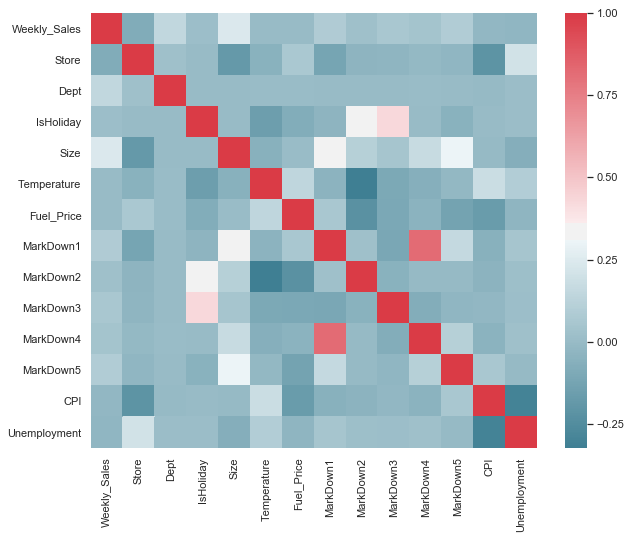

In [8]:
sns.set(style="white")
fig1, ax1 = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_train.corr(), cmap=cmap)


#### Unsurprisingly, size has a clear positive correlation with weekly sales, and  negative correlation with CPI / Unemployment 

#### Lets check for features correlation in test data as well

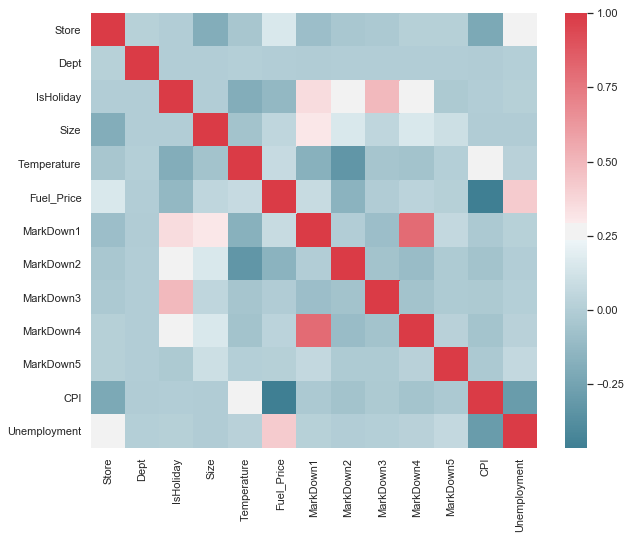

In [9]:
sns.set(style="white")
fig2, ax2 = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_test.corr(), cmap=cmap)

Interestingly, Test data show clear negative correlation between Fuel Price and CPI. 

## <span style="color:blue"><u>4. Handling Nulls and creating new features relevant for this time series data</u></span>

### 4.1. Feature Engineering..create new feature to indicate presence of MarkDown Data
There are multiple nulls in markdown columns, specially in training data. Considering the importanec of the same for holiday period sales prediction, let us first create features just to indicate if markdowns are present or absent..

In [10]:
# New features to indicate that MarkDown data is available
df_train = df_train.assign(Is_M1 = df_train.MarkDown1.notnull())
df_train = df_train.assign(Is_M2 = df_train.MarkDown2.notnull())
df_train = df_train.assign(Is_M3 = df_train.MarkDown3.notnull())
df_train = df_train.assign(Is_M4 = df_train.MarkDown4.notnull())
df_train = df_train.assign(Is_M5 = df_train.MarkDown5.notnull())

df_test = df_test.assign(Is_M1 = df_test.MarkDown1.notnull())
df_test = df_test.assign(Is_M2 = df_test.MarkDown2.notnull())
df_test = df_test.assign(Is_M3 = df_test.MarkDown3.notnull())
df_test = df_test.assign(Is_M4 = df_test.MarkDown4.notnull())
df_test = df_test.assign(Is_M5 = df_test.MarkDown5.notnull())

In [11]:
df_train.tail(2)

,Weekly_Sales,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Is_M1,Is_M2,Is_M3,Is_M4,Is_M5
421568,760.01,45,98,2012-10-19,False,B,118221,56.47,3.969,2004.02,...,3.18,437.73,1537.49,192.330854,8.667,True,False,True,True,True
421569,1076.80,45,98,2012-10-26,False,B,118221,58.85,3.882,4018.91,...,100.00,211.94,858.33,192.308899,8.667,True,True,True,True,True


### 4.2 Fill nulls in MarkDown fields with 0, and in CPI/Unemployment columns with last valid values 
Having created additional features to indicate presence of markdown data, let us fill all Nulls in markdown fields with '0'.
For CPI/Unemployment nulls, filling with last valid value seem to be better choice rather than filling with average/median or nulls. pandas has `'ffill'` method to achieve the same.

In [12]:
# fill markdown nulls with 0, CPI/Unemployment Nulls using forward fill (last valid value)

print('Nulls before filling values')
print ('Nulls in training data')
df_train.isnull().sum().sum()

print ('Nulls in test data')
df_test.isnull().sum().sum()

df_train.fillna(0, inplace=True)
df_test.CPI.fillna(method ='ffill', inplace=True)
df_test.Unemployment.fillna(method ='ffill', inplace=True)
df_test.fillna(0, inplace = True)

print('Nulls after filling values')
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

Nulls before filling values
Nulls in training data


1422431

Nulls in test data


127817

Nulls after filling values


(0, 0)

In [13]:
# check data types
df_test.dtypes

Store             int64
Dept              int64
Date             object
IsHoliday          bool
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Is_M1              bool
Is_M2              bool
Is_M3              bool
Is_M4              bool
Is_M5              bool
dtype: object

### 4.3 Convert Date field to datatime format, that will help us in extracting Month/Week feature

In [14]:
# Convert 'Date' column to 'datetime' format
df_train['Date'] = pd.to_datetime(df_train['Date'], infer_datetime_format=True)
df_test['Date'] = pd.to_datetime(df_test['Date'], infer_datetime_format=True)

# to ease with one hot encoding, lets convert IsHoliday feature to 'uint8'
df_train.IsHoliday = df_train.IsHoliday.astype('uint8')
df_test.IsHoliday = df_test.IsHoliday.astype('uint8')

In [15]:
df_train.head(2)

,Weekly_Sales,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Is_M1,Is_M2,Is_M3,Is_M4,Is_M5
0,24924.50,1,1,2010-02-05,0,A,151315,42.31,2.572,0.0,...,0.0,0.0,0.0,211.096358,8.106,False,False,False,False,False
1,46039.49,1,1,2010-02-12,1,A,151315,38.51,2.548,0.0,...,0.0,0.0,0.0,211.242170,8.106,False,False,False,False,False


### 4.4 Creating new feature for Month

In [16]:
df_train['Month']= df_train.Date.dt.month.map(str)
df_test['Month']= df_test.Date.dt.month.map(str)

# Also Convert Store/Dept columns to type 'Object' to help for One-Hot-Encoding later

df_train['Store'] ='S'+df_train.Store.map(str)
df_train['Dept'] = 'D'+df_train.Dept.map(str)

df_test['Store'] = 'S'+df_test.Store.map(str)
df_test['Dept'] = 'D'+df_test.Dept.map(str)

### 4.5. Create new features for Median Sales and Median Markdowns
We will create a grouped dataframe with stores/Dept/Month/IsHoliday as the index. we will use the same index for merging these new features with our main train and test datasets.

In [17]:
# First create a separate dataframe with Median data grouped together for Store/Dept/Month/Hoiliday
median_sales = df_train.pivot_table(index = ['Store', 'Dept', 'Month', 'IsHoliday'], 
                                                 values = ['Weekly_Sales'], aggfunc = np.median) 

median_markdowns_train = df_train.pivot_table(index = ['Store', 'Dept', 'Month', 'IsHoliday'], 
                                                 values = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], 
                                                 aggfunc = np.median) 

median_markdowns_test = df_test.pivot_table(index = ['Store','Dept', 'Month', 'IsHoliday'], 
                                                 values = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], 
                                                 aggfunc = np.median) 

median_sales.columns = ['Median_Sales']
median_markdowns_train.columns = ['Median_MarkDown1','Median_MarkDown2', 'Median_MarkDown3', 
                                  'Median_MarkDown4', 'Median_MarkDown5']
median_markdowns_test.columns = ['Median_MarkDown1','Median_MarkDown2', 'Median_MarkDown3', 
                                 'Median_MarkDown4', 'Median_MarkDown5']

median_sales.head(2)
median_markdowns_train.head(2)
median_markdowns_test.head(2)


Median_Sales
Store Dept Month IsHoliday              
S1    D1   1     0             17350.585
           10    0             23388.030

Median_MarkDown1  Median_MarkDown2  \
Store Dept Month IsHoliday                                       
S1    D1   1     0                    582.23            541.37   
           10    0                      0.00              0.00   

                            Median_MarkDown3  Median_MarkDown4  \
Store Dept Month IsHoliday                                       
S1    D1   1     0                     16.94               5.5   
           10    0                      0.00               0.0   

                            Median_MarkDown5  
Store Dept Month IsHoliday                    
S1    D1   1     0                   611.095  
           10    0                     0.000

Median_MarkDown1  Median_MarkDown2  \
Store Dept Month IsHoliday                                       
S1    D1   1     0                  2493.385          9847.030   
           11    0                  8231.360          1831.495   

                            Median_MarkDown3  Median_MarkDown4  \
Store Dept Month IsHoliday                                       
S1    D1   1     0                     8.025           235.990   
           11    0                    77.300          2386.525   

                            Median_MarkDown5  
Store Dept Month IsHoliday                    
S1    D1   1     0                  2920.210  
           11    0                  6383.425

### 4.6 Merge Median Sales feature to train and test data 

In [18]:
df_train = df_train.merge(median_sales, how = 'left', on = ['Dept','Store','Month','IsHoliday'])
df_test = df_test.merge(median_sales, how = 'left', on = ['Dept','Store','Month','IsHoliday'])

In [19]:
# Check Nulls after merging
df_test.isnull().sum()

Store             0
Dept              0
Date              0
IsHoliday         0
Type              0
Size              0
Temperature       0
Fuel_Price        0
MarkDown1         0
MarkDown2         0
MarkDown3         0
MarkDown4         0
MarkDown5         0
CPI               0
Unemployment      0
Is_M1             0
Is_M2             0
Is_M3             0
Is_M4             0
Is_M5             0
Month             0
Median_Sales    658
dtype: int64

#### lets fill nulls in median sales with median of the column

In [20]:
df_test.Median_Sales.fillna(df_test.Median_Sales.median(),inplace = True)
df_test.isnull().sum().sum()

0

### 4.7 Merging median MarkDowns

In [21]:
# shape and nulls before merging median MarkDowns
print(f'train and test dataframe shape before merging median markdowns: {df_train.shape, df_test.shape}')
print(f'Nulls in train and test dataframe are {df_train.isnull().sum().sum(), df_test.isnull().sum().sum()}')


df_train = df_train.merge(median_markdowns_train, how = 'left', on = ['Dept','Store','Month','IsHoliday'])
df_test = df_test.merge(median_markdowns_test, how = 'left', on = ['Dept','Store','Month','IsHoliday'])

# shape and nulls after merging median MarkDowns
print(f'train and test dataframe shape after merging median markdowns:{df_train.shape, df_test.shape}')
print(f'Nulls in train and test dataframe are {df_train.isnull().sum().sum(), df_test.isnull().sum().sum()}')

train and test dataframe shape before merging median markdowns: ((421570, 23), (115064, 22))
Nulls in train and test dataframe are (0, 0)
train and test dataframe shape after merging median markdowns:((421570, 28), (115064, 27))
Nulls in train and test dataframe are (0, 0)


### 4.8 Feature Engineering..create new features to indicate weeks during, before and after special holidays
Considering the importance of markdowns explicitely mentioned in the dataset, we will create some new features to indicate if a specific week is covering  Superbowl, Christmas, Thanksgiving and Labor Day holiday. 

The dates are already provided with the dataset. In order to cover the impact of sales before or after the special holiday week, we will also create new features to indicate the same. 

#### First create our lists of weeks with special holidays ,week before and week after

In [22]:
Super_Bowl = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'] # 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor_Day = ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'] #10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving = ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'] # 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas = ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'] # 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

Before_Super_Bowl = ['2010-02-5', '2011-02-4', '2012-02-3', '2013-02-01'] 
Before_Labor_Day = ['2010-09-3', '2011-09-02', '2012-08-31', '2013-08-30'] 
Before_Thanksgiving = ['2010-11-19', '2011-11-18', '2012-11-16', '2013-11-22'] 
Before_Christmas = ['2010-12-24', '2011-12-23', '2012-12-21', '2013-12-20']

After_Super_Bowl = ['2010-02-19', '2011-02-18', '2012-02-17', '2013-02-15'] 
After_Labor_Day = ['2010-09-17', '2011-09-16', '2012-09-14', '2013-09-13'] 
After_Thanksgiving = ['2010-12-03', '2011-12-02', '2012-11-30', '2013-12-06'] 
After_Christmas = ['2011-01-07', '2012-01-06', '2013-01-04', '2014-01-03'] 

#to make our task easier, lets make a list of lists containg dates of special holiday related weeks
super_list = [Super_Bowl, Labor_Day, Thanksgiving, Christmas, 
         Before_Super_Bowl, Before_Labor_Day, Before_Thanksgiving, Before_Christmas,
         After_Super_Bowl, After_Labor_Day, After_Thanksgiving, After_Christmas]

#### Now create these additional 12  features in both train and test dataframes 

In [23]:
# create a list of new feature names
new_feature = ['Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas', 
         'Before_Super_Bowl', 'Before_Labor_Day', 'Before_Thanksgiving', 'Before_Christmas',
         'After_Super_Bowl', 'After_Labor_Day', 'After_Thanksgiving', 'After_Christmas']

# iterate through above lists and create new features 
for i in range(len(super_list)):

    df_train[new_feature[i]] = np.where((df_train.Date.isin(super_list[i])), True, False)
    df_test[new_feature[i]] = np.where((df_test.Date.isin(super_list[i])), True, False)

In [24]:
df_train.head(2)

,Weekly_Sales,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,Thanksgiving,Christmas,Before_Super_Bowl,Before_Labor_Day,Before_Thanksgiving,Before_Christmas,After_Super_Bowl,After_Labor_Day,After_Thanksgiving,After_Christmas
0,24924.50,S1,D1,2010-02-05,0,A,151315,42.31,2.572,0.0,...,False,False,True,False,False,False,False,False,False,False
1,46039.49,S1,D1,2010-02-12,1,A,151315,38.51,2.548,0.0,...,False,False,False,False,False,False,False,False,False,False


## <span style="color:blue"><u>5. One Hot Encoding</u></span>
Before proceeding to apply learning models, we will convert all categorical('string') features to new features using One Hot Encoding. This is much less relevant for Random Forest alogorithms, but critical for other category of models.

In [25]:
# Create One_hot_encoded features (pandas considers all columns of dtype 'Object' for OHE, unless separately provided)
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

# Check for difference in train and test dataset after OHE (Common problem if categories are not consistent in train and test data)
set(df_train.columns.tolist()) - set(df_test.columns.tolist())
len(df_train.columns.tolist()), len(df_test.columns.tolist())

{'Month_10', 'Month_8', 'Month_9', 'Weekly_Sales'}

(177, 173)

It seem that test data has no records for months 8, 9 & 10. However in order to run machine learning models, both train and test data should have common set of feature variables, so we will create 3 new dummy features for these months..

In [26]:
#lets create dummy columns with false values for missing months in test dataset (also convert to uint8 for ease with OHE)
missed_months = ['Month_10', 'Month_8', 'Month_9']
for month in missed_months:
    df_test[month]=False
    df_test[month]=df_test[month].astype('uint8')

# Check the difference between train and test data columns again to verify that only target variable is extra in train data
set(df_train.columns.tolist()) - set(df_test.columns.tolist())
len(df_train.columns.tolist()), len(df_test.columns.tolist())

{'Weekly_Sales'}

(177, 176)

#### Final check on Nulls

In [27]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

#### Align relative feature positions in train and test dataset(Must do before training models)
Also remember that 'Weekly_Sales' is at first column position in train data, but absent in test data'..

In [28]:
# lets align the columns in test dataframe with train dataframe 
df_test = df_test[df_train.columns.tolist()[1:]]

#Verify
df_train.columns[1:] == df_test.columns
# for i in range(len(df_test.columns)):
#     print(df_train.columns[i+1], df_test.columns[i])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

#### We will convert all boolean features to 'uint' format to avoid creating 2 features by one hot encoding (Indicating 'yes/no'), where only one is needed

In [29]:
# convert bool types to 'uint8' (as with other OHE columns before training models)
bools1 = df_train.select_dtypes(include=['bool']).columns.tolist()
bools2 = df_test.select_dtypes(include=['bool']).columns.tolist()

bools1 == bools2

for item in bools1:
    df_train[item]=df_train[item].astype('uint8')
for item in bools2:
    df_test[item]=df_test[item].astype('uint8')


True

##  <span style="color:blue"><u>6.Create new Dataframe for train/test features and target variables</u></span>

In [30]:
# Create Train, Target and Test dataframes for models
X_train = df_train.drop('Weekly_Sales', axis =1)
X_test = df_test
y_train = df_train.Weekly_Sales.values.reshape(-1)

X_train.shape, y_train.shape, X_test.shape

((421570, 176), (421570,), (115064, 176))

## <span style="color:blue"><u>7. Feature scaling</u></span>

#### scaling of int64 and floats
#### ( drop date index, if exists, as it gives error for reindexing in below step)


In [31]:
#Feature scaling of numeric columns (excluding 'uint8')

to_scale = ['Size',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Median_Sales',
 'Median_MarkDown1',
 'Median_MarkDown2',
 'Median_MarkDown3',
 'Median_MarkDown4',
 'Median_MarkDown5']


# Creating various temporary dataframes for extracting numeric columns, balance columns and merging

temporary1 = X_train[to_scale]
temporary2 = X_test[to_scale]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# create data frame of numeric columns after scaling
A = scaler.fit_transform(temporary1)
B = scaler.transform(temporary2)
A_df = pd.DataFrame(A, columns = to_scale)
B_df = pd.DataFrame(B, columns = to_scale)

# merge with balance of the original dataframe
A1_df = X_train.drop(to_scale, axis =1)
B1_df = X_test.drop(to_scale, axis =1)
# A1_df.head()

X_train = pd.concat([A1_df, A_df], axis =1)
X_test = pd.concat([B1_df, B_df], axis =1)

X_train.set_index('Date', inplace = True, drop = True)
X_test.set_index('Date', inplace = True, drop = True)

print('Scaled train dataset')
X_train.describe()
print('Scaled test dataset')
X_test.describe()
X_train.head(2)

Scaled train dataset


,IsHoliday,Is_M1,Is_M2,Is_M3,Is_M4,Is_M5,Super_Bowl,Labor_Day,Thanksgiving,Christmas,...,MarkDown4,MarkDown5,CPI,Unemployment,Median_Sales,Median_MarkDown1,Median_MarkDown2,Median_MarkDown3,Median_MarkDown4,Median_MarkDown5
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,...,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,0.070358,0.357428,0.263890,0.325192,0.320153,0.359210,0.021100,0.021019,0.014135,0.014104,...,0.016052,0.015322,0.446165,0.391153,0.026337,0.002553,0.004333,0.002972,0.000549,0.003038
std,0.255750,0.479243,0.440741,0.468447,0.466536,0.479769,0.143717,0.143448,0.118049,0.117922,...,0.057718,0.038773,0.387069,0.178579,0.033390,0.013149,0.028914,0.027893,0.007358,0.010739
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.058898,0.288672,0.005777,0.000000,0.000918,0.000006,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.556049,0.382116,0.014030,0.000000,0.000918,0.000006,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.006303,0.019978,0.853554,0.449780,0.032728,0.000000,0.000918,0.000006,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Scaled test dataset


,IsHoliday,Is_M1,Is_M2,Is_M3,Is_M4,Is_M5,Super_Bowl,Labor_Day,Thanksgiving,Christmas,...,MarkDown4,MarkDown5,CPI,Unemployment,Median_Sales,Median_MarkDown1,Median_MarkDown2,Median_MarkDown3,Median_MarkDown4,Median_MarkDown5
count,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.0,115064.000000,115064.0,115064.000000,115064.000000,...,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000
mean,0.077592,0.998705,0.751208,0.914578,0.887993,1.0,0.025760,0.0,0.025864,0.025968,...,0.044169,0.036147,0.505160,0.281483,0.026632,0.117673,0.023535,0.014035,0.043117,0.048896
std,0.267529,0.035962,0.432315,0.279510,0.315377,0.0,0.158418,0.0,0.158730,0.159041,...,0.106885,0.179186,0.408133,0.151380,0.034060,0.163141,0.055258,0.092947,0.110655,0.042610
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,-0.001706,0.051125,-0.018689,0.001886,-0.013104,0.000576,-0.000626,0.000000,-0.002939
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.001043,0.012065,0.122179,0.168679,0.005929,0.045050,0.000918,0.000106,0.003379,0.023255
50%,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.008901,0.022028,0.655286,0.279088,0.014236,0.085291,0.004817,0.000492,0.014490,0.039716
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.038946,0.038954,0.964200,0.394192,0.032948,0.139684,0.018823,0.001041,0.037901,0.060041
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.0,1.000000,1.000000,...,0.968430,7.108858,1.017235,0.605712,1.000000,1.751019,0.680302,1.055445,1.219026,0.687817


,IsHoliday,Is_M1,Is_M2,Is_M3,Is_M4,Is_M5,Super_Bowl,Labor_Day,Thanksgiving,Christmas,...,MarkDown4,MarkDown5,CPI,Unemployment,Median_Sales,Median_MarkDown1,Median_MarkDown2,Median_MarkDown3,Median_MarkDown4,Median_MarkDown5
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.840500,0.405118,0.038054,0.0,0.000918,0.000006,0.0,0.0
2010-02-12,1,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.841941,0.405118,0.059713,0.0,0.000918,0.000006,0.0,0.0


## <span style="color:blue"><u>8. Train a Random Forest Regressor </u></span>

### 8.1 Note on performance metric used
In sklearn, RandomForrest Regressor 'criterion' is The function to measure the quality of a split.
It's a performance measure (by default, MSE) which helps the algorithm to decide on a rule for an optimum split on a node 
in a tree.

Kaggle competition rule gave us a metric 'mean absolute error' to evaluate the performance of our model i.e. the results would be judged basis mae between y_true and y_predicted. So using 'mse' criterion in random forest is absolutely fine.

While both MAE/ MSE are performance measures, they are being used at two different stages of a modeling process. 

### 8.2 Cross Validation with Random Forest of 100 trees

In [32]:
# # Run cross validation with 100 trees

# X = X_train.values
# y = y_train
# X.shape, y.shape

# from sklearn import model_selection
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score

# rfr = RandomForestRegressor(criterion= 'mse', n_estimators=100, max_depth =None, verbose=2, n_jobs=-3, min_samples_split=2, min_samples_leaf=1)

# scores = cross_val_score(rfr, X, y, cv=5, scoring = 'neg_mean_absolute_error')    

# print(f"Cross-validation scores:{scores}")
# print(f"Mean is {scores.mean()} and std is {scores.std()}.")

### 8.3 Running final round with test validation split of 80:20
(This is after trying performance with 50 & 500 trees also, 100 tree seem to be optimum balance between performance and speed)

In [33]:
# Using our entire training data to learn and predict
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.20)
print(f'train/val split of training data is Train:{Xtrain.shape,ytrain.shape} and Validation:{Xval.shape, yval.shape}')

Xtest = X_test.values


rfr = RandomForestRegressor(criterion= 'mse', 
                            n_estimators=100, 
                            max_depth =None, 
                            verbose=1, 
                            n_jobs=-3, 
                            min_samples_split=2, 
                            min_samples_leaf=1,
                            random_state  = 0)

rfr.fit(Xtrain, ytrain)

MAE_validation  = mean_absolute_error(yval, rfr.predict(Xval))
print(f'Mean Absolute Error on validation data is {MAE_validation}')

train/val split of training data is Train:((337256, 175), (337256,)) and Validation:((84314, 175), (84314,))


[Parallel(n_jobs=-3)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:  4.6min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-3,
                      oob_score=False, random_state=0, verbose=1,
                      warm_start=False)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s


Mean Absolute Error on validation data is 1408.5535211518848


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.9s finished


#### Mean Absolute Error with predictions on validation sample is 1376

### 8.4 saving the model - file size 2.5 GB!!

In [34]:
# from sklearn.externals import joblib

# # save the model to local machine
# filename = 'output_data/RandomForest_100.sav'
# joblib.dump(rfr, filename)
 
# # load the model from disk
# rfr = joblib.load(filename)

### 8.5 Run prediction on our test data and save results

In [35]:
# Predictions on Test dataset
yhat = rfr.predict(Xtest)

print('Saving Predictions on test dataset as "predicted.csv"')
results = pd.DataFrame(yhat.reshape(-1,1), columns = ['Weekly_Sales'])

results.to_csv("output_data/y_predicted.csv")

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished


Saving Predictions on test dataset as "predicted.csv"


In [36]:
results.head()

,Weekly_Sales
0,25391.4636
1,21819.6593
2,24260.6294
3,24811.8381
4,21756.5383


In [37]:
#Merge results into test data file
test = pd.read_csv("dataset/original/test.csv")
train = pd.read_csv("dataset/original/train.csv")
test = pd.concat([test, results], axis =1)
test= test[train.columns.tolist()]
print('merged predicted weekly sales to test data file')
train.shape, test.shape

#Merge to a common file having Sales data both train and test dataset(predicted one for test dataset)
print(test.columns == train.columns)
train_test_sales = pd.concat([train, test], axis =0)
train_test_sales.to_csv("output_data/train_test_sales.csv")


# Saving unscaled files used for machine learning 
df_train.to_csv("output_data/raw_train(final).csv")
df_test.to_csv("output_data/raw_test(final).csv")
df_train.shape, df_test.shape

merged predicted weekly sales to test data file


((421570, 5), (115064, 5))

[ True  True  True  True  True]


((421570, 177), (115064, 176))

## <span style="color:blue"><u>9. Plot a simple matplotlib chart </u></span>
To check if seasonal/annual trending of sales are visible in predicated sales.

In [38]:
#Group the sales data by weeks 
group = train_test_sales.groupby('Date').mean().reset_index()
group.set_index('Date', inplace = True, drop = True)
y_chart = group.Weekly_Sales.tolist()
x_chart = group.index.tolist()


#### plot a line chart using indexes (dates) and sale values (train & test data put together)

(182, 182)

Text(0.5, 0.95, 'Actual Sales')

Text(0.9, 0.95, 'Predicted Sales')

<function matplotlib.pyplot.show(*args, **kw)>

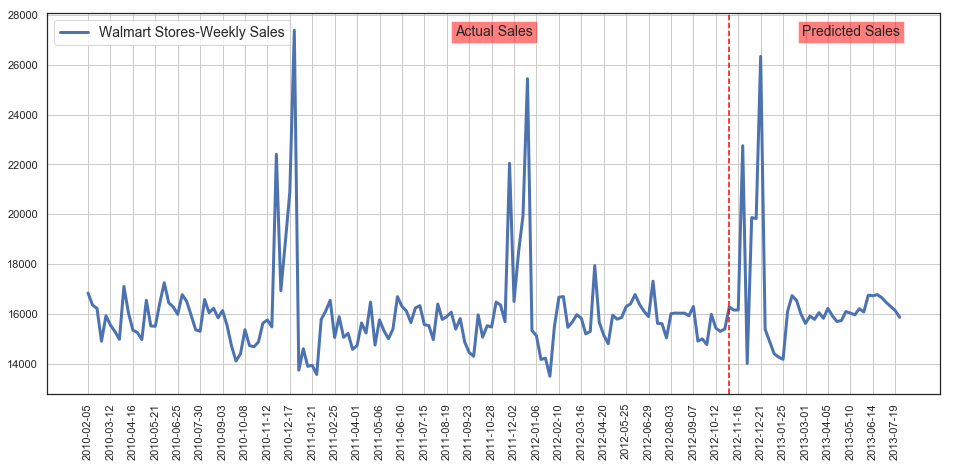

In [40]:
len(y_chart), len(x_chart)
fig3, ax3 = plt.subplots(figsize = (16,7))
ax3.plot(x_chart, y_chart, label = 'Walmart Stores-Weekly Sales', linewidth =3)
ax3.legend(loc = 'upper left', fontsize =14)
ax3.set_xticks(ax3.get_xticks()[::5])
ax3.tick_params(axis='x', rotation=90)
ax3.grid()
plt.axvline(x=143, color = 'red', linestyle ='--', label = 'Test Data' )
ax3.text(0.5, 0.95,'Actual Sales', horizontalalignment='center', verticalalignment='center', transform = ax3.transAxes, 
         bbox=dict(facecolor='red', alpha=0.5), fontsize =14)
ax3.text(0.9, 0.95,'Predicted Sales', horizontalalignment='center', verticalalignment='center', transform = ax3.transAxes, 
         bbox=dict(facecolor='red', alpha=0.5), fontsize =14)

fig3.savefig('output_data/Walmart_sales')
plt.show

### <span style="color:red">So our predicted sales are showing a similar trending as in case of sales data</span>
### <span style="color:red">The mean absolute error for these predictions is 3335 as checked by kaggle submission</span>

## <span style="color:blue">10. Saving Data Files</span>

In [ ]:
train_dept = pd.read_csv("output_data/train1.csv")
test_dept = pd.read_csv("output_data/test1.csv")
dept = pd.read_csv("dataset/department_names.csv")

In [ ]:
train_dept = pd.merge(train_dept, dept, how = 'left', on='Dept')
test_dept = pd.merge(test_dept, dept, how = 'left', on='Dept')


In [ ]:
train_dept.columns, test_dept.columns
keep = ['Weekly_Sales', 'Store', 'Dept', 'Dept_Name', 'Date', 'IsHoliday',
        'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
        'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Month',
        'Median_Sales', 'Labor_Day', 'Christmas', 'Thanksgiving', 'Super_Bowl',
        'Before_Labor_Day', 'Before_Christmas', 'Before_Thanksgiving',
        'Before_Super_Bowl', 'After_Labor_Day', 'After_Christmas',
        'After_Thanksgiving', 'After_Super_Bowl']
train_dept=train_dept[keep]
test_dept=test_dept[keep]

In [ ]:
train_dept.head(2)
test_dept.head(2)

In [ ]:
train_dept.to_csv("output_data/train_for_analysis.csv")
test_dept.to_csv("output_data/test_for_analysis.csv")

# .....#

# End of notebook